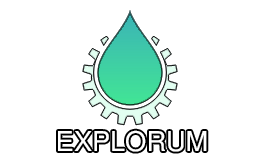

# -------------------------------------------------------------------------------------------
#### - Saleh Atwah
#### - Obai Shaikh



### <a>1.1. Background</a>
Well logs are interpreted/processed to estimate the in-situ petrophysical and geomechanical properties, which is essential for subsurface characterization. Various types of logs exist, and each provides distinct information about subsurface properties. Certain well logs, like gamma ray (GR), resistivity, density, and neutron logs, are considered as “easy-to-acquire” conventional well logs that are run in most of the wells. Other well logs, like nuclear magnetic resonance, dielectric dispersion, elemental spectroscopy, and sometimes sonic logs, are only run in limited number of wells.

Sonic travel-time logs contain critical geomechanical information for subsurface characterization around the wellbore. Often, sonic logs are required to complete the well-seismic tie workflow or geomechanical properties prediction. When sonic logs are absent in a well or an interval, a common practice is to synthesize them based on its neighboring wells that have sonic logs. This is referred to as sonic log synthesis or pseudo sonic log generation.


### <a>1.2. Problem Statement</a>
Compressional travel-time (DTC) and shear travel-time (DTS) logs are not acquired in all the wells drilled in a field due to financial or operational constraints. Under such circumstances, machine learning techniques can be used to predict DTC and DTS logs to improve subsurface characterization. The goal of the “SPWLA’s 1st Petrophysical Data-Driven Analytics Contest” is to develop data-driven models by processing “easy-to-acquire” conventional logs from Well #1, and use the data-driven models to generate synthetic compressional and shear travel-time logs (DTC and DTS, respectively) in Well #2. A robust data-driven model for the desired sonic-log synthesis will result in low prediction errors, which can be quantified in terms of Root Mean Squared Error by comparing the synthesized and the original DTC and DTS logs.

You are provided with two datasets: train.csv and test.csv. You need to build a generalizable data-driven models using train dataset. Following that, you will deploy the newly developed data-driven models on test dataset to predict DTS and DTC logs. The data-driven model should use feature sets derived from the following 7 logs: Caliper, Neutron, Gamma Ray, Deep Resistivity, Medium Resistivity, Photo-electric factor and density. The data-driven model should synthesize two target logs: DTC and DTS logs.

The predicted values should be in the same format as sample_submission.csv, and submit together with your notebook for evaluation. 

### <a>1.3. Data Decription</a>
#### Files
&gt; #### train.csv
All the values equals to -999 are marked as missing values.
- CAL - Caliper, unit in Inch,  
- CNC - Neutron, unit in dec 
- GR - Gamma Ray, unit in API
- HRD - Deep Resisitivity, unit in Ohm per meter,
- HRM - Medium Resistivity, unit in Ohm per meter,
- PE - Photo-electric Factor, unit in Barn,
- ZDEN - Density, unit in Gram per cubit meter, 
- DTC - Compressional Travel-time, unit in nanosecond per foot,
- DTS - Shear Travel-time, unit in nanosecond per foot,


&gt; #### test.csv
The test data has all features that you used in the train dataset, except the two sonic curves DTC and DTS.

&gt; ####   real_result_20perc.csv
20% randomly sampled from orginal data.


&gt; ####  sample_submission.csv
A valid sample submission.
<p><font style="">
</font></p>

### <a>1.4. Evaluation Metric</a>
We will be evaluated by the metirc `Root Mean Squared Error`.

The RMSE is calculated as:

$ ϵ=∑_i \sqrt{ ∑_n (y_p - y_t)^2 /n } $

Where:
- y_p is the predicted curve for DTC and DTS
- y_t is the true value for evaluation.

DTC and DTS are in the same weight during the evaluation 

Understanding and optimizing your predictions for this evaluation metric is paramount for this compeition.

## <a>2a. Imports</a>

In [144]:
# !jupyter nbextension enable --py widgetsnbextension
# #you are my saver!
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager
# # import libraries
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive
from sklearn.preprocessing import FunctionTransformer
from copy import copy
from sklearn.svm import LinearSVR
import pandas_profiling
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
# import sklearn libararies
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.preprocessing import StandardScaler, QuantileTransformer, Normalizer, PowerTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression 
from sklearn.neural_network import MLPRegressor
from sklearn.impute import SimpleImputer 
from sklearn.feature_selection import SelectFwe, VarianceThreshold, f_regression
from sklearn.feature_selection import SelectFwe, f_regression
from sklearn.linear_model import ElasticNetCV
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
from sklearn.model_selection import RandomizedSearchCV 


## <a>2b. define functions</a>

In [27]:
def result_plot(y_predict, y_real):
    # check the accuracy of predicted data and plot the result
    print('Root Mean Square Error is:', '{:.5f}'.format(np.sqrt(mean_squared_error(y_real, y_predict))))
    plt.subplots(nrows=2, ncols=2, figsize=(16,10))
    plt.subplot(2, 2, 1)
    plt.plot(y_real[:, 0])
    plt.plot(y_predict[:, 0])
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('DTC')
    plt.title('DTC Prediction Comparison')

    plt.subplot(2, 2, 2)
    plt.plot(y_real[:, 1])
    plt.plot(y_predict[:, 1])
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('DTS')
    plt.title('DTS Prediction Comparison')
    
    plt.subplot(2, 2, 3)
    plt.scatter(y_real[:, 0], y_predict[:, 0])
    plt.xlabel('Real Value')
    plt.ylabel('Predicted Value')
    plt.title('DTC Prediction Comparison')
    
    plt.subplot(2, 2, 4)
    plt.scatter(y_real[:, 1], y_predict[:, 1])
    plt.xlabel('Real Value')
    plt.ylabel('Predicted Value')
    plt.title('DTS Prediction Comparison')

    plt.show()

In [28]:
def log_plot(logs):
    #sort dta by depth
    logs = logs.sort_values(by='Depth')
   
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    f, ax = plt.subplots(nrows=1, ncols=9, figsize=(17, 10))
    ax[0].plot(logs.CAL, logs.Depth, '-g')
    ax[1].plot(logs.CNC, logs.Depth, '-')
    ax[2].plot(logs.GR, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.HRD, logs.Depth, '-', color='r')
    ax[4].plot(logs.HRM, logs.Depth, '-', color='black')
    ax[5].plot(logs.PE, logs.Depth, '-g')
    ax[6].plot(logs.ZDEN, logs.Depth, '-')
    ax[7].plot(logs.DTC, logs.Depth, '-', color='0.5')
    ax[8].plot(logs.DTS, logs.Depth, '-', color='r')
    
    for i in range(len(ax)):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=10)
    
    ax[0].set_xlabel("CAL")
    ax[0].set_xlim(logs.CAL.min(),logs.CAL.max())
    ax[1].set_xlabel("CNC")
    ax[1].set_xlim(logs.CNC.min(),0.75)
    ax[2].set_xlabel("GR")
    ax[2].set_xlim(logs.GR.min(),logs.GR.max())
    ax[3].set_xlabel("HRD")
    ax[3].set_xlim(logs.HRD.min(),logs.HRD.max())
    ax[4].set_xlabel("HRM")
    ax[4].set_xlim(logs.HRM.min(),logs.HRM.max())
    ax[5].set_xlabel("PE")
    ax[5].set_xlim(0,logs.PE.max())
    ax[6].set_xlabel("ZDEN")
    ax[6].set_xlim(logs.ZDEN.min(),logs.ZDEN.max())
    ax[7].set_xlabel("DTC")
    ax[7].set_xlim(logs.DTC.min(),logs.DTC.max())
    ax[8].set_xlabel("DTS")
    ax[8].set_xlim(logs.DTS.min(),logs.DTS.max())
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([]); ax[6].set_yticklabels([])
    ax[7].set_yticklabels([]); ax[8].set_yticklabels([])

    
    plt.show()

## <a>3. work / data science</a>

In [133]:
# loading data
data = pd.read_csv('train.csv')          



In [93]:
ls

 alias.py*
 all_volve_data_finalll.csv*
 cudnnrnn.py*
 cwrnn.py*
 Data3_1_2020.zip*
'Deep Learning -try.ipynb'*
 DTC_25_4_2020-testing.py*
 DTC_Data.csv*
 DTC_xxxxx.py*
 DTS_25_4_2020-testing.py*
 DTS_Data.csv*
 DTS_xxxxx.py*
'Explorum Solution.ipynb'*
 FINAL-EXAMPLE.ipynb*
 logo.png*
'New Text Document.txt'*
 old_tries-tpot/
 __pycache__/
 README.md*
 real_result_20perc.csv*
 saleh_ai.py*
 sample_submission.csv*
'SPWLA PDDA Contest Announcement.pdf'*
 SPWLA.tar.gz*
'Synthetic Sonic Log Generation Starter_Yu 2_27_2020.ipynb'*
 test/
 test.csv*
'test LSTM.ipynb'*
 traincompined.csv*
 train.csv*
 train_DTC.csv*
 train_DTS.csv*
 training_data_no_nan.csv*
 volve_raw.csv*
 yaml.yaml*


In [134]:

# remove all rows that contains missing value
data.replace(['-999', -999], np.nan, inplace=True)
# # data.dropna(axis=0, inplace=True)

data.replace(['-999', -999], np.nan, inplace=True)
# data.dropna(axis=0, inplace=True)

data=data.reset_index()

In [39]:
data.head()

,index,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
0,573,14.8824,0.5173,57.1903,1.9826,1.9726,27.9432,2.3510,125.9611,306.8676
1,574,14.9570,0.4966,63.1593,2.0472,1.6373,28.1064,2.4055,125.9726,305.8347
2,575,14.6341,0.4433,64.5217,2.0464,1.4866,26.5968,2.4579,125.8528,305.9089
3,576,14.2318,0.4309,63.0144,2.0054,1.4613,19.5635,2.4219,125.7362,305.1737
4,577,14.0163,0.4469,60.8421,1.9533,1.4438,9.8556,2.3138,125.9774,304.4476


In [14]:
# #Deep/Medium Resistivity are intrepeted in a log10 scale therefore a conversion is needed 
# data['HRD']= np.log10(data.HRD)
# data['HRM']= np.log10(data.HRM)

In [15]:
# add depth track
data['Depth']=data.index

In [16]:
data.head()

,index,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS,Depth
0,0,NaN,NaN,41.4699,NaN,NaN,NaN,NaN,128.0737,319.0654,0
1,1,NaN,NaN,42.5053,NaN,NaN,NaN,NaN,127.8347,318.7825,1
2,2,NaN,NaN,43.1548,NaN,NaN,NaN,NaN,127.2307,317.3323,2
3,3,NaN,NaN,43.2410,NaN,NaN,NaN,NaN,126.2917,313.6486,3
4,4,NaN,NaN,40.3218,NaN,NaN,NaN,NaN,125.3985,307.8903,4


In [17]:
#cool gadget ;)
pandas_profiling.ProfileReport(data)

KeyboardInterrupt: 

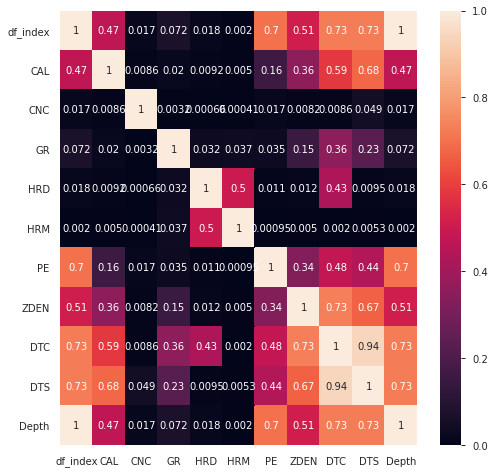

In [18]:
corr = np.abs(data.corr().dropna())
plt.figure(figsize=(8,8))
sns.heatmap(corr, annot=True,  vmin=0, vmax=1) 

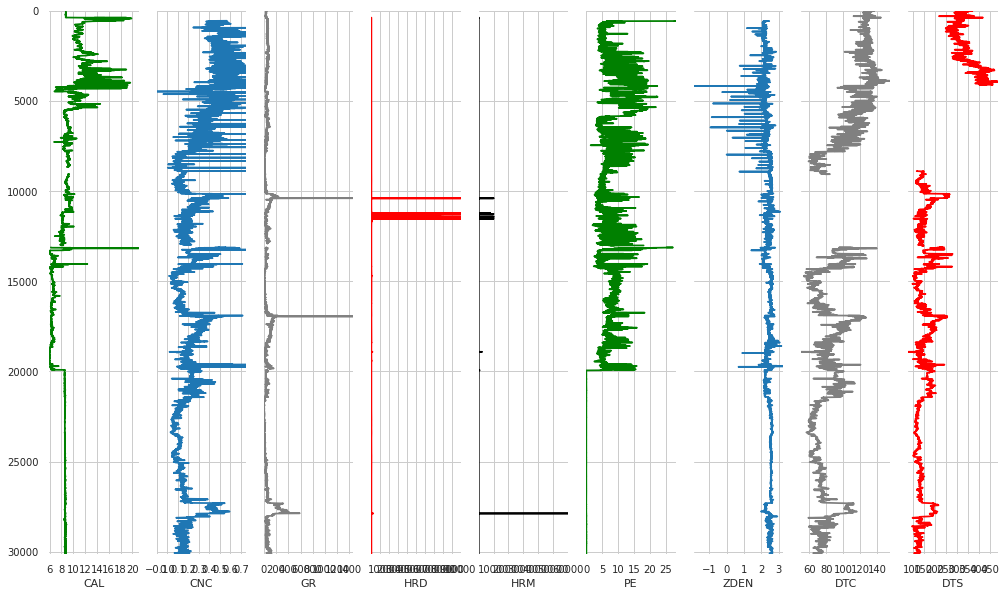

In [19]:
log_plot(data)

there's an interval where there's DTS data but no DTC and the oppisite also happens ,

there fore two seperate models needs to be fitted

In [135]:
data['PE'][data['PE']<0.5]=0
data.replace(0, np.nan, inplace=True)

/home/atwahsz/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [21]:
#DTC DATA

In [136]:
DTC_train = data.loc[data['DTC'].notnull(), ['CAL','CNC','GR','HRD', 'HRM', 'PE','ZDEN','DTC' ]].dropna().reset_index()

In [137]:
DTC_train['Depth']=DTC_train.index
DTC_train['DTS']='NaN'

In [99]:
DTC_train.to_csv('train_DTC.csv',index=False)

In [15]:
log_plot(DTC_train)

NameError: name 'log_plot' is not defined

In [25]:
#DTS DATA

In [138]:
DTS_train = data.loc[data['DTC'].notnull(), ['CAL','CNC','GR','HRD', 'HRM', 'PE','ZDEN','DTS' ]].dropna().reset_index()

In [139]:
DTS_train['Depth']=DTS_train.index
DTS_train['DTC']='NaN'

In [102]:
DTS_train.to_csv('train_DTS.csv',index=False)

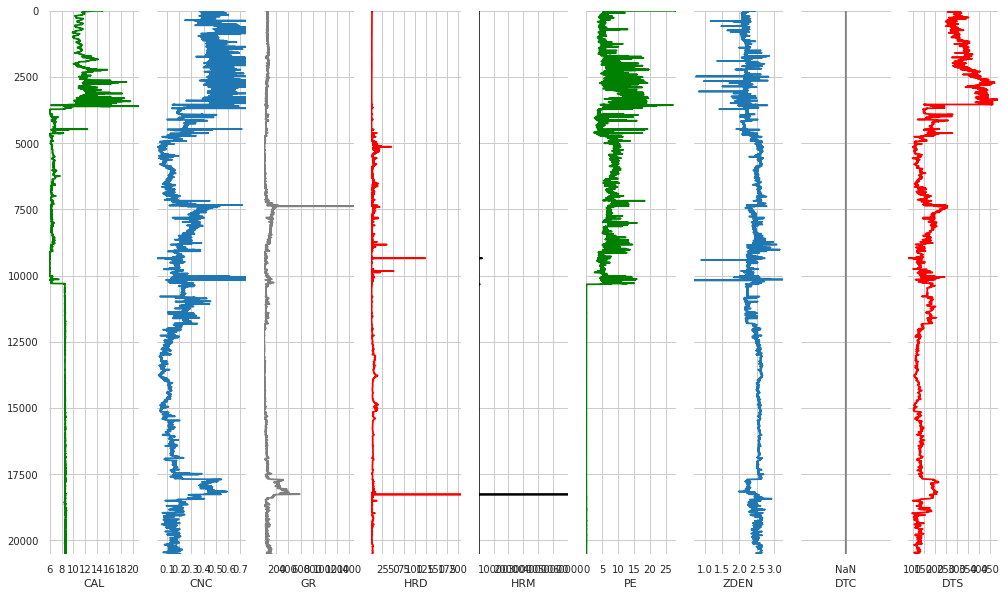

In [30]:
log_plot(DTS_train)

In [31]:
list(data.columns)

['df_index',
 'CAL',
 'CNC',
 'GR',
 'HRD',
 'HRM',
 'PE',
 'ZDEN',
 'DTC',
 'DTS',
 'Depth']

In [140]:
features=['CAL','CNC', 'GR', 'HRD', 'HRM','PE',  'ZDEN']
target=['DTC','DTS']
#training DTC
DTC_train_=DTC_train[features].to_numpy()

DTC_target_=DTC_train['DTC'].to_numpy()

#training DTS
DTS_train_=DTS_train[features].to_numpy()


DTS_target_=DTS_train['DTS'].to_numpy()

## Splitting training and testing AND SCALING

In [141]:
XDTC_train, XDTC_test, yDTC_train, yDTC_test = train_test_split(DTC_train_, DTC_target_,
                                                                test_size=0.2, random_state=100)

XDTS_train, XDTS_test, yDTS_train, yDTS_test = train_test_split(DTS_train_,DTS_target_,
                                                                test_size=0.2, random_state=100)

In [34]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.
/home/atwahsz/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/atwahsz/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/atwahsz/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/atwahsz/.local/lib/python3.7/site-packages/tensorflow/py

In [ ]:
model = Sequential()
model.add(LSTM(50, input_shape=(XDTC_train.shape, train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [142]:
    # Scale testing sets
    scaler = StandardScaler().fit(XDTC_train)
    XDTC_train_sca = scaler.transform(XDTC_train)

    # Scale testing sets
    XDTC_test_sca = StandardScaler().fit_transform(XDTC_test)
    


In [145]:
    # Scale testing sets
    scaler = PowerTransformer().fit(XDTS_train)
    XDTS_train_sca = scaler.transform(XDTS_train)

    # Scale testing sets
    XDTS_test_sca = PowerTransformer().fit_transform(XDTS_test)

## FITTING TPOT ##

In [1018]:
from tpot import TPOTRegressor
DTC_pipelne_opt = TPOTRegressor(verbosity=2, scoring='r2', cv=10, subsample=0.5,
                      n_jobs=-1, generations=100, config_dict='TPOT sparse',
                      population_size=100, random_state=100,
                      early_stop = 35)

In [1019]:
#fit from DTC_24_4_2020.py
DTC_pipelne_opt.fit(XDTC_train_sca,yDTC_train)

Generation 1 - Current best internal CV score: 0.9716300965061242


TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: RandomForestRegressor(input_matrix, bootstrap=False, max_features=0.15000000000000002, min_samples_leaf=2, min_samples_split=2, n_estimators=100)


TPOTRegressor(config_dict='TPOT sparse', crossover_rate=0.1, cv=10,
              disable_update_check=False, early_stop=35, generations=100,
              max_eval_time_mins=5, max_time_mins=None, memory=None,
              mutation_rate=0.9, n_jobs=-1, offspring_size=None,
              periodic_checkpoint_folder=None, population_size=100,
              random_state=100, scoring='r2', subsample=0.5, template=None,
              use_dask=False, verbosity=2, warm_start=False)

In [1020]:
DTC_pipelne_opt.export('DTC_25_4_2020-testing.py')

In [1021]:
DTS_pipelne_opt = TPOTRegressor(verbosity=2, scoring='r2', cv=10, subsample=0.5,
                      n_jobs=-1, generations=100, config_dict='TPOT sparse',
                      population_size=100, random_state=100,
                      early_stop = 35)

In [1022]:
DTS_pipelne_opt.fit(XDTC_train,yDTS_train)

ValueError: Error: Input data is not in a valid format. Please confirm that the input data is scikit-learn compatible. For example, the features must be a 2-D array and target labels must be a 1-D array.

In [ ]:
DTS_pipelne_opt.export('DTS_25_4_2020-testing.py')


In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold, SelectPercentile
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from xgboost import XGBRegressor
from tpot.export_utils import set_param_recursive

In [33]:
DTC_model=  XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=0.7777777777777777,
               gamma=0.6666666666666666, gpu_id=-1, importance_type='gain',
               interaction_constraints=None, learning_rate=0.18, max_delta_step=0,
               max_depth=60, min_child_weight=12, 
               monotone_constraints=None, n_estimators=100, n_jobs=0,
               num_parallel_tree=1, objective='reg:squarederror', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
               tree_method=None, validate_parameters=False, verbosity=None)

In [34]:
DTS_model= XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=0.7777777777777777,
               gamma=0.6666666666666666, gpu_id=-1, importance_type='gain',
               interaction_constraints=None, learning_rate=0.18, max_delta_step=0,
               max_depth=60, min_child_weight=12, 
               monotone_constraints=None, n_estimators=100, n_jobs=0,
               num_parallel_tree=1, objective='reg:squarederror', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
               tree_method=None, validate_parameters=False, verbosity=None)

## testing the models ##

In [124]:
#fitting the models
DTC_model.fit(XDTC_train,yDTC_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7777777777777777,
             gamma=0.6666666666666666, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.18, max_delta_step=0,
             max_depth=60, min_child_weight=12, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method=None, validate_parameters=False, verbosity=None)

In [125]:
DTS_model.fit(XDTS_train,yDTS_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7777777777777777,
             gamma=0.6666666666666666, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.18, max_delta_step=0,
             max_depth=60, min_child_weight=12, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method=None, validate_parameters=False, verbosity=None)

In [111]:
DTC_benchmark_prediction = DTC_model.predict(XDTC_test_sca)
DTS_benchmark_prediction = DTS_model.predict(XDTS_test_sca)

In [112]:
#scoring each model to see preformnce
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse_DTC = sqrt(mean_squared_error(yDTC_test, DTC_benchmark_prediction))
rmse_DTS = sqrt(mean_squared_error(yDTS_test, DTS_benchmark_prediction))
print(" DTC  :",rmse_DTC)
print(" DTS  :", rmse_DTS)

 DTC  : 9.65399682876967
 DTS  : 29.842734301101274


In [1127]:
#Bench marking on 20% of Hidden Data Set


In [1128]:
ls

 alias.py*
 all_volve_data_finalll.csv*
 Data3_1_2020.zip*
 DTC_25_4_2020-testing.py*
 DTC_xxxxx.py*
 DTS_25_4_2020-testing.py*
 DTS_xxxxx.py*
'Explorum Solution.ipynb'*
 FINAL-EXAMPLE.ipynb*
 logo.png*
'New Text Document.txt'*
 old_tries-tpot/
 __pycache__/
 README.md*
 real_result_20perc.csv*
 saleh_ai.py*
 sample_submission.csv*
'SPWLA PDDA Contest Announcement.pdf'*
 SPWLA.tar.gz*
'Synthetic Sonic Log Generation Starter_Yu 2_27_2020.ipynb'*
 test/
 test.csv*
 traincompined.csv*
 train.csv*
 yaml.yaml*


In [156]:
benchmark_20 = pd.read_csv('test.csv')    
# benchmark_20 = pd.read_csv('test.csv')    
# benchmark_20['HRD']= np.log10(benchmark_20.HRD)
# benchmark_20['HRM']= np.log10(benchmark_20.HRM)
benchmark_20['Depth']=benchmark_20.index

In [157]:
ls

 alias.py*
 all_volve_data_finalll.csv*
 cudnnrnn.py*
 cwrnn.py*
 Data3_1_2020.zip*
'Deep Learning -try.ipynb'*
 DTC_25_4_2020-testing.py*
 DTC_Data.csv*
 DTC_xxxxx.py*
 DTS_25_4_2020-testing.py*
 DTS_Data.csv*
 DTS_xxxxx.py*
'Explorum Solution.ipynb'*
 FINAL-EXAMPLE.ipynb*
 logo.png*
'New Text Document.txt'*
 old_tries-tpot/
 __pycache__/
 README.md*
 real_result_20perc.csv*
 saleh_ai.py*
 sample_submission.csv*
'SPWLA PDDA Contest Announcement.pdf'*
 SPWLA.tar.gz*
'Synthetic Sonic Log Generation Starter_Yu 2_27_2020.ipynb'*
 test/
 test.csv*
'test LSTM.ipynb'*
 traincompined.csv*
 train.csv*
 train_DTC.csv*
 train_DTS.csv*
 training_data_no_nan.csv*
 volve_raw.csv*
 yaml.yaml*


In [158]:
benchmark_20_x_train= benchmark_20[features].values

In [159]:
benchmark_20_y_true=benchmark_20[target].values

KeyError: "None of [Index(['DTC', 'DTS'], dtype='object')] are in the [columns]"

In [160]:
benchmark_20_x_train_sca = StandardScaler().fit_transform(benchmark_20_x_train)


In [161]:
DTC_benchmark_20_prediction = DTC_model.predict(benchmark_20_x_train)
DTS_benchmark_20_prediction = DTS_model.predict(benchmark_20_x_train)

In [162]:
benchmark_20_y_pred = pd.DataFrame({'DTC':DTC_benchmark_20_prediction,'DTS':DTS_benchmark_20_prediction}, columns=['DTC','DTS'])

In [154]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse_DTC = sqrt(mean_squared_error(benchmark_20.DTC, DTC_benchmark_20_prediction))
rmse_DTS = sqrt(mean_squared_error(benchmark_20.DTS, DTS_benchmark_20_prediction))
print(" DTC  :",rmse_DTC)
print(" DTS  :", rmse_DTS)

 DTC  : 9.001449807453922
 DTS  : 23.579666709536507


Root Mean Square Error is: 17.84694


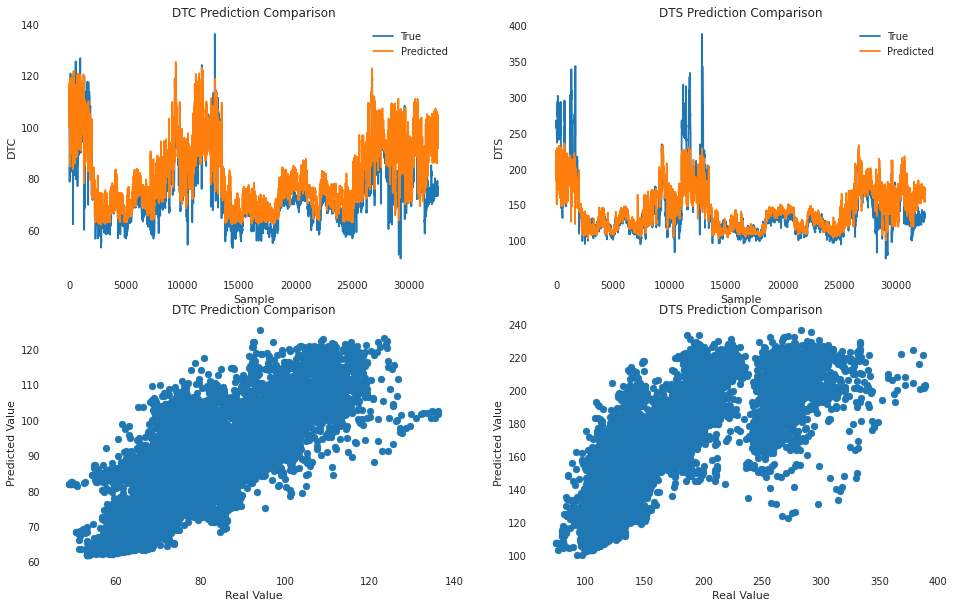

In [155]:
result_plot(benchmark_20_y_pred, benchmark_20_y_true)

In [164]:
benchmark_20_y_pred.to_csv('Explorum_submission_3.csv',index=False)